# Deep Learning Project: Image Classification Using the MNIST Dataset

## Problem Description

The MNIST dataset is a widely used dataset in machine learning, consisting of 70,000 images of handwritten digits (0-9). The goal of this project is to develop a deep learning model that can accurately classify these images into their respective digit categories.

## Data Collection and Provenance

The MNIST dataset is available on [Kaggle](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). It is a well-established dataset with a clear provenance, making it suitable for this project. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scikeras.wrappers import KerasClassifier, KerasRegressor

2024-10-03 06:02:31.180310: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 06:02:31.235768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# configure GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-10-03 06:02:33.765583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20561 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [3]:
# Load the MNIST dataset from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## 1. Data Inspection

In [4]:
print("Dataset Description:")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nData Distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} images")


Dataset Description:
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)

Data Distribution:
Digit 0: 5923 images
Digit 1: 6742 images
Digit 2: 5958 images
Digit 3: 6131 images
Digit 4: 5842 images
Digit 5: 5421 images
Digit 6: 5918 images
Digit 7: 6265 images
Digit 8: 5851 images
Digit 9: 5949 images


## 2. Visualization

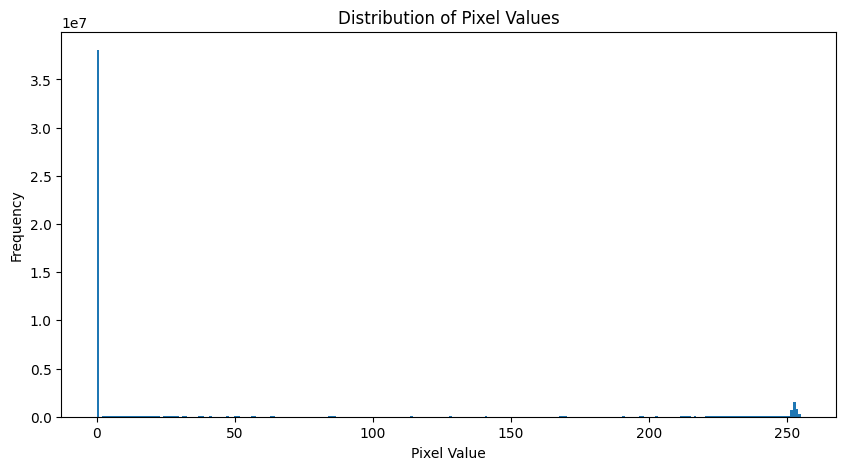

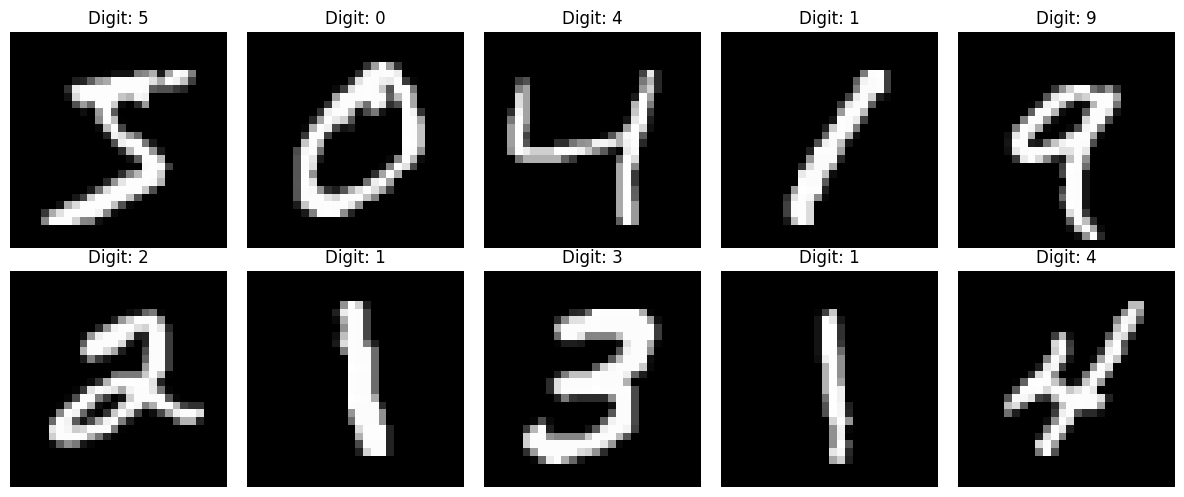

In [5]:
# Histogram of pixel values
plt.figure(figsize=(10, 5))
plt.hist(X_train.ravel(), bins=256)
plt.title("Distribution of Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Digit: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## 3. Data Cleaning


In [6]:
# Check for missing values, as the data is already preprocessed, there should be no missing values
print("\nMissing Values:")
print(f"Training set: {np.isnan(X_train).sum()}")
print(f"Test set: {np.isnan(X_test).sum()}")


Missing Values:
Training set: 0
Test set: 0


## 4. Data Transformation


In [7]:
# Normalize pixel values
X_train_norm = X_train.astype('float32') / 255
X_test_norm = X_test.astype('float32') / 255

# Reshape for CNN input
X_train_reshaped = X_train_norm.reshape(X_train_norm.shape[0], 28, 28, 1)
X_test_reshaped = X_test_norm.reshape(X_test_norm.shape[0], 28, 28, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Model Analysis
## 1. Model Selection and 2. Model Building

In [8]:
# build simple dense model
def build_dense_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

In [9]:
dense_model = build_dense_model((28,28,1))

# Compiling the Model
dense_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Training the Model
dense_history = dense_model.fit(X_train, y_train, epochs=10, 
                                validation_data=(X_test, y_test))

Epoch 1/10


2024-10-03 06:02:37.153192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-03 06:02:37.188132: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0f46ccf1a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-03 06:02:37.188166: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-10-03 06:02:37.194262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 06:02:37.214360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-10-03 06:02:37.350509: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 6s 3ms/step - loss: 2.1836 - accuracy: 0.8587 - val_loss: 0.4124 - val_accuracy: 0.9006
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3625 - accuracy: 0.9129 - val_loss: 0.3442 - val_accuracy: 0.9123
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2873 - accuracy: 0.9283 - val_loss: 0.4228 - val_accuracy: 0.9052
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2522 - accuracy: 0.9356 - val_loss: 0.2923 - val_accuracy: 0.9251
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2356 - accuracy: 0.9400 - val_loss: 0.2752 - val_accuracy: 0.9345
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2159 - accuracy: 0.9451 - val_loss: 0.2585 - val_accuracy: 0.9426
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2112 - accuracy: 0.9451 - val_loss: 0.2693 - val_accuracy: 0.9428
Epo

In [10]:
# Building the Model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

cnn_model = build_cnn_model((28,28,1))

# Compiling the Model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Training the Model
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, 
                            validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.3262 - accuracy: 0.9496 - val_loss: 0.0689 - val_accuracy: 0.9779
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0657 - accuracy: 0.9801 - val_loss: 0.0582 - val_accuracy: 0.9830
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0493 - accuracy: 0.9845 - val_loss: 0.0703 - val_accuracy: 0.9816
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0438 - accuracy: 0.9867 - val_loss: 0.0482 - val_accuracy: 0.9855
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0367 - accuracy: 0.9886 - val_loss: 0.0518 - val_accuracy: 0.9864
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0316 - accuracy: 0.9906 - val_loss: 0.0699 - val_accuracy: 0.9828
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.0761 - val_accuracy:

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Lambda, GlobalAveragePooling2D


# Building the Model
def build_transfer_learning_model():
    base_model = MobileNetV2(input_shape=(96, 96, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    def preprocess_input(x):
        # Resize images to (96, 96)
        x = tf.image.resize(x, [96, 96])
        # Convert grayscale images to RGB by repeating the channel
        x = tf.image.grayscale_to_rgb(x)
        return x

    model = Sequential([
        Lambda(preprocess_input, input_shape=(28, 28, 1)),
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model

transfer_model = build_transfer_learning_model()

# Compiling the Model
transfer_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Training the Model
transfer_history = transfer_model.fit(X_train, y_train, epochs=10, 
                                      validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 15s 6ms/step - loss: 0.2020 - accuracy: 0.9344 - val_loss: 0.1765 - val_accuracy: 0.9415
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1210 - accuracy: 0.9613 - val_loss: 0.1136 - val_accuracy: 0.9637
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0977 - accuracy: 0.9681 - val_loss: 0.1354 - val_accuracy: 0.9566
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0836 - accuracy: 0.9721 - val_loss: 0.1023 - val_accuracy: 0.9693
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0713 - accuracy: 0.9765 - val_loss: 0.0945 - val_accuracy: 0.9712
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0640 - accuracy: 0.9782 - val_loss: 0.1008 - val_accuracy: 0.9680
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0526 - accuracy: 0.9818 - val_loss: 0.1081 - val_ac

# 3. Results and Discussion

In [12]:
# Helper Function for Evaluation
from sklearn.metrics import accuracy_score
class_names = [str(i) for i in range(10)]
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(f'Classification Report for {model_name}')
    print(classification_report(y_test, y_pred_classes, target_names=class_names))
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return accuracy

313/313 [==============================] - 0s 1ms/step
Classification Report for Dense Model
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.95      0.92      0.94      1010
           4       0.96      0.94      0.95       982
           5       0.93      0.95      0.94       892
           6       0.96      0.95      0.96       958
           7       0.98      0.92      0.95      1028
           8       0.85      0.95      0.90       974
           9       0.93      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000



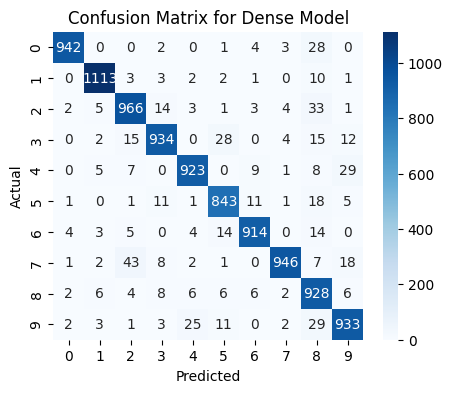

In [13]:
dense_accuracy = evaluate_model(dense_model, X_test, y_test, 'Dense Model')

313/313 [==============================] - 1s 1ms/step
Classification Report for CNN Model
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



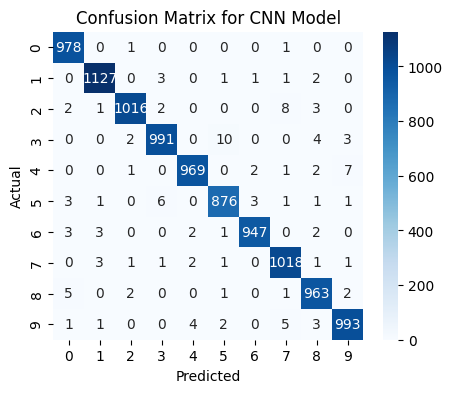

In [14]:
cnn_accuracy = evaluate_model(cnn_model, X_test, y_test, 'CNN Model')

313/313 [==============================] - 2s 4ms/step
Classification Report for Transfer Learning Model
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.98      0.93      0.95      1010
           4       0.98      0.98      0.98       982
           5       0.92      0.97      0.94       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.94      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



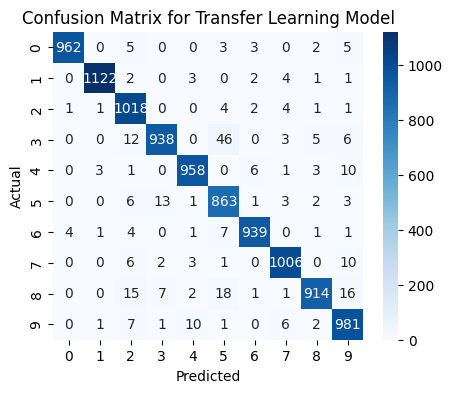

In [15]:
tlm_accuracy = evaluate_model(transfer_model, X_test, y_test, 'Transfer Learning Model')

In [16]:
print("Model Comparison:")
print(f"Simple NN Accuracy: {dense_accuracy:.4f}")
print(f"CNN Accuracy: {cnn_accuracy:.4f}")
print(f"Transfer Learning Model Accuracy: {tlm_accuracy:.4f}")
print(f"Improvement for CNN: {(cnn_accuracy - dense_accuracy) * 100:.2f}%")
print(f"Improvement for Transfer Learning Model: {(tlm_accuracy - dense_accuracy) * 100:.2f}%")

Model Comparison:
Simple NN Accuracy: 0.9442
CNN Accuracy: 0.9878
Transfer Learning Model Accuracy: 0.9701
Improvement for CNN: 4.36%
Improvement for Transfer Learning Model: 2.59%


## Observations

### Dense Model
- **Accuracy**: 0.94
- **Precision, Recall, F1-Score**: Generally high, but lower for class '8' with an F1-score of 0.87.
- **Confusion Matrix**: Misclassifications are more frequent in classes '3', '5', and '8', indicating potential areas for improvement.

### CNN Model
- **Accuracy**: 0.98
- **Precision, Recall, F1-Score**: Very high across all classes, with F1-scores ranging from 0.98 to 0.99.
- **Confusion Matrix**: Minimal misclassifications, demonstrating strong performance across all classes.

### Transfer Learning Model
- **Accuracy**: 0.97
- **Precision, Recall, F1-Score**: High but slightly lower than the CNN model. Class '5' has a lower F1-score of 0.95.
- **Confusion Matrix**: Similar to the Dense model, some misclassifications occur in classes '3', '5', and '9'.

## Discussion/Conclusion

- **Performance Comparison**:
  - The **CNN Model** outperforms both the Dense and Transfer Learning models in terms of accuracy and F1-scores across most classes. This suggests that the CNN model is better at capturing spatial hierarchies in data.
  - The **Dense Model** has the lowest accuracy and struggles particularly with class '8'. This indicates that a simple dense architecture might not be sufficient for complex patterns.
  - The **Transfer Learning Model** performs better than the Dense model but slightly worse than the CNN model. It shows good generalization but may need fine-tuning on specific classes like '5'.

- **Recommendations**:
  - For tasks requiring high accuracy and precision, the CNN model is preferable.
  - Consider further tuning or augmenting data for classes where misclassifications are frequent, especially in the Dense and Transfer Learning models.
  - Investigate the potential of combining models or using ensemble techniques to improve performance on challenging classes.

In conclusion, the CNN model demonstrates superior capability in this classification task.